# Micropython in the notebook

**Useful links**

http://docs.micropython.org/en/latest/pyboard/

http://docs.micropython.org/en/latest/pyboard/pyboard/quickref.html

**Table of contents**

1. [Micropython board layout](#Micropython-board-layout)
2. [pyboard initialisation](#pyboard-initialisation)
3. [Cell magic](#Cell-magic)
4. [Capturing data from the pyboard](#Capturing-data-from-the-pyboard)
5. [Code completion and inspection](#Code-completion-and-inspection)
6. [pyboard.py](#pyboard.py)


One difficulty with the micropython board is that, in a certain respect, it is not so trivial to develop code for it. What I mean is that the terminal, while has code completion capabilities, is still just a black-and-white terminal, and therefore, doesn't lend itself to syntax highlighting. 

The situation becomes even worse, when chunks of code have to be written and re-written: the command history can only encompass 10 lines, and thus, one has to brace for a lot of typing. 

Of course, both issues can be alleviated by working in a dedicated code editor, and then copying the code file to the board. But this can't exactly be called interactive code development, can it?

As it turns out, these problems can easily be solved in the ipython notebook, in fact, it doesn't even take more than a couple of lines of code. Without further ado, here are the gory details.

In [54]:
from IPython.display import Image

from IPython.core.magic import register_cell_magic

import pyboard

Above, we have a couple of imports. The first one is optional, and I only used it to display the micropython board. 

The second import enables us to write a very simple cell magic function, by the help of which we can easily either execute highlit code, or save it to the board's flash memory or SD card.

The third import is the communication interface between the computer and the board. Originally, I took code from ..., but for completeness, I listed it [at the end of this notebook](#pyboard.py).

## Micropython board layout

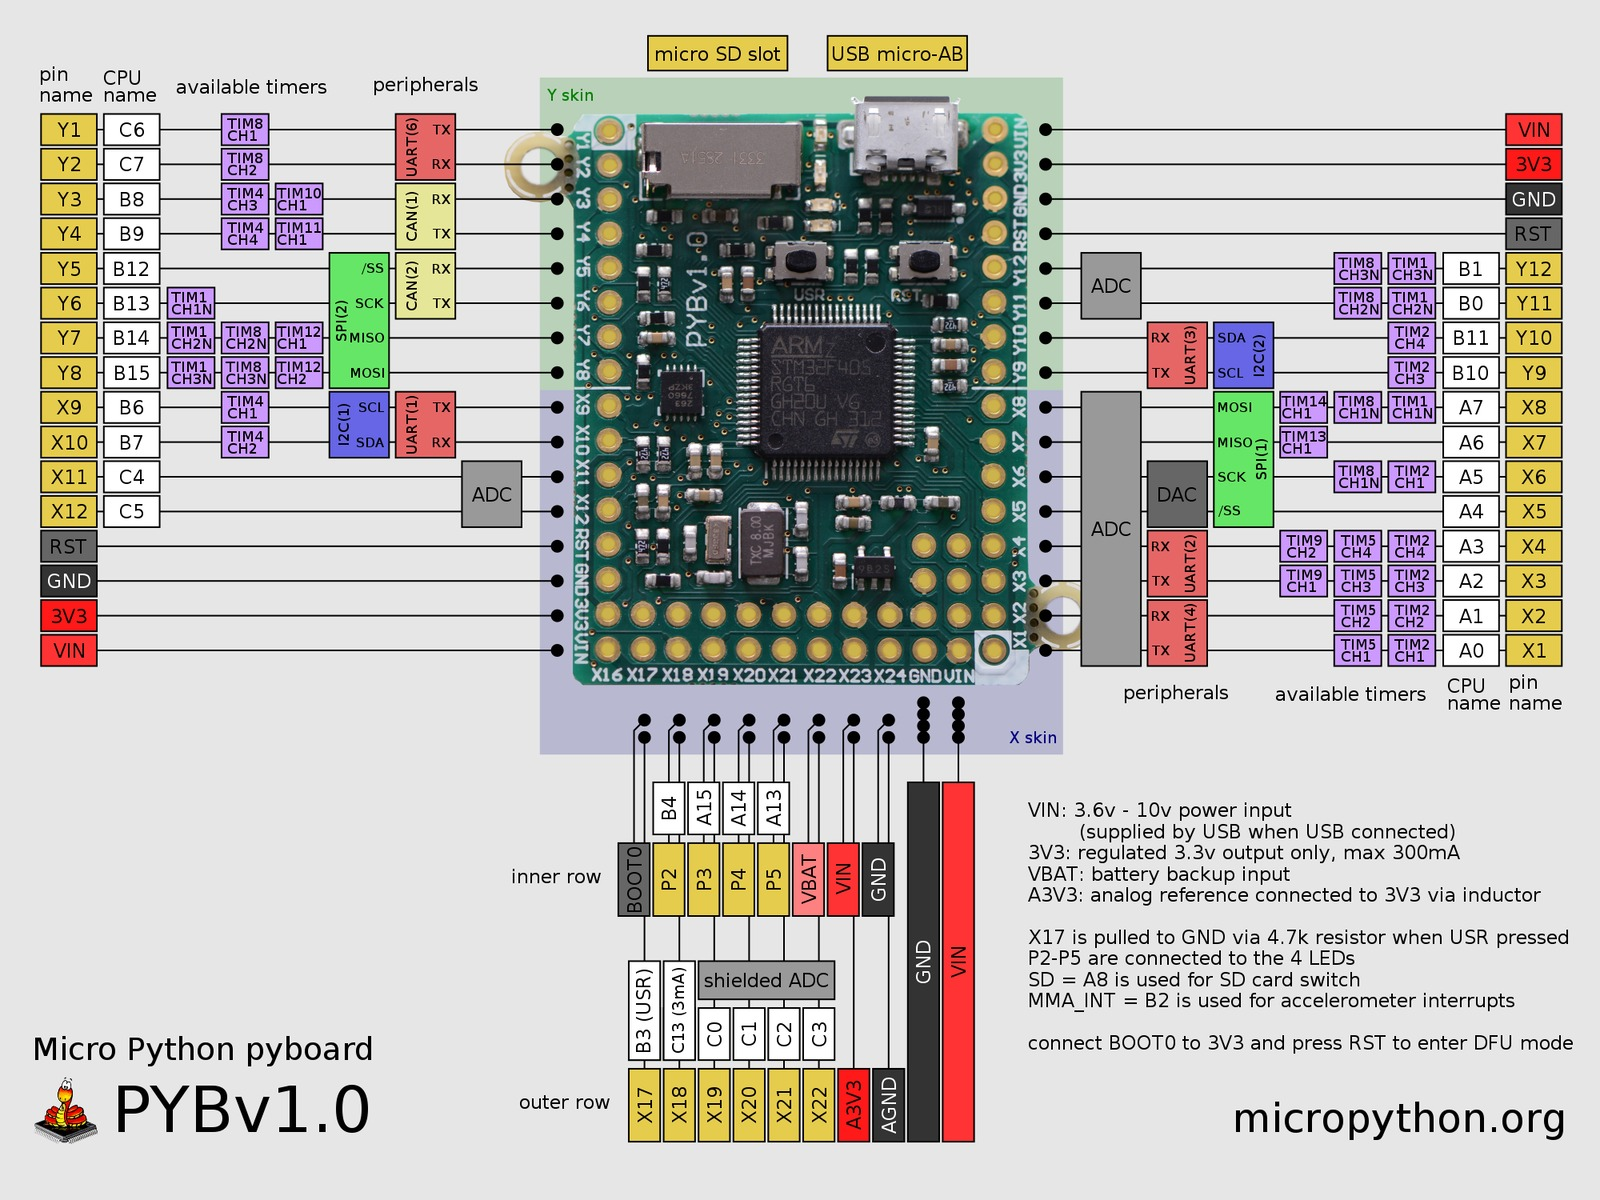

In [3]:
Image('pybv10-pinout.jpg', width=900)

## pyboard initialisation

Once pyboard is loaded, the board itself has to be initialised as 

```python
pyb = pyboard.Pyboard('/dev/ttyACM2')
pyb.enter_raw_repl()
```
or whatever the file corresponding to your board is. Then code segments can be executed with 

```python
pyb.exec('code segment')
```

At the end, the board can be disconnected from the python interpreter (on the computer) with the command 

```python
pyb.exit_raw_repl()
```

In [55]:
pyb = pyboard.Pyboard('/dev/ttyACM0')
pyb.enter_raw_repl()

## Cell magic

As advertised above, we want to create a cell magic that loads code to the board, and executes it there. Details of how to write various magic commands can be found here https://ipython.org/ipython-doc/3/config/custommagics.html. Here I confine myself to the absolute minimum. In particular, we will write a magic function that either executes the code of the cell on the board, or writes the code to some place, if an *argument* is given. Here is the code listing.

In [191]:
@register_cell_magic
def pyboard(line, cell):
    if len(line) != 0: 
        try:
            with open(line, 'w') as fout:
                fout.write(cell)
        except:
            print('Failed to write to disc!')
        return
    else:
        return pyb.exec(cell)

Well, this is it. Eleven lines, not more. And here is how you would use it in real life. Again, assuming that 

```python
import pyboard
pyb = pyboard.Pyboard('/dev/ttyACM2')
pyb.enter_raw_repl()
```
has been executed somewhere, we simply write

In [ ]:
%%pyboard

import utime
import pyb

def blink_led(n, ms):
    for i in range(n):
        pyb.LED(2).toggle()
        utime.sleep_ms(ms)
    
blink_led(10, 400)

in which case the code is executed, or 

In [ ]:
%%pyboard /mnt/pythonboard/modules/init.py

import time
import pyb

def blink_led(n, ms):
    for i in range(n):
        pyb.LED(2).toggle()
        time.sleep_ms(ms)

If we do something illegal, we get a nicely formatted traceback, as demonstrated here.

In [9]:
%%pyboard

def define_something_stupid(n, ms)
    for i in range(n):
        pyb.LED(2).toggle()
        time.sleep_ms(ms)

PyboardError: ('exception', b'', b'Traceback (most recent call last):\r\n  File "<stdin>", line 3\r\nSyntaxError: invalid syntax\r\n')

## Capturing data from the pyboard

One advantage of accessing the pyboard from a proper high-level kernel instead of letting the kernel run on the board itself is that data originating from the board can then be analysed in a high-level environment. In the following example, we collect 100 ADC measurements, and plot it with matplotlib. We will make use of the fact that the output of 
```python
pyb.exec('code to execute')
```
ends up in the notebook. In particular, print statements print to the notebook.

In [43]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


The cell above was executed in the notebook, and not on the board. That comes now. The following definition pertains to the board.

In [29]:
%%pyboard

import time
from pyb import ADC

adc = ADC(Pin('X12'))

def board_measure(n, delay):
    out = 0
    for i in range(n): 
        print(adc.read())
        time.sleep_ms(delay)

b''

This function is going to run in the notebook.

In [44]:
def notebook_measure(n, delay):
    ret_val = pyb.exec('board_measure(%d, %d)'%(n, delay))
    return array([int(x) for x in ret_val.split()])

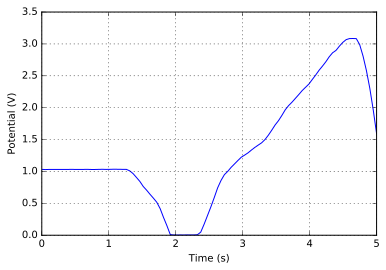

In [50]:
t = linspace(0, 5, 100)
volt = notebook_measure(100, int(1000*(t[1]-t[0])))*3.3/4095

plot(t, volt)
xlabel('Time (s)')
ylabel('Potential (V)')
grid()

## Code completion and inspection

Our original magic function can execute code on the board, but code completion and inspection does not work most of the time. The reason for that is that the ipython kernel knows absolutely nothing about imports executed on the board itself. In a sense, the kernel is blind to the code sitting on the board. 

As it turns out, it is relatively simple to fix this problem. All one has to do is to allow the kernel to import the modules. For this reason, there has to be an importable, but otherwise not functional micropython module (otherwise, the kernel would try to run code meant for the board). So, e.g., the ujson module for the kernel should look something like this:

In [ ]:
# %load ujson.py
def dumps(obj):

    """Return obj represented as a JSON string."""
    pass

def loads(str):

    """Parse the JSON str and return an object. Raises ValueError if the string is not correctly formed."""
    pass


Now, we have to extend our original magic function a bit, and import the modules. The following magic function allows imports in three forms:

1. import module1, module2, module3...
2. import module as mod
3. from module import object1, object2, object3...

In [192]:
@register_cell_magic
def pyboard(line, cell):
    if len(line) != 0: 
        try:
            with open(line, 'w') as fout:
                fout.write(cell)
        except:
            print('Failed to write to disc!')
        return
    else:
        try:
            pyb.exec(cell)
        except:
            print('pyboard is not connected to computer...')
        for line in cell.split('\n'):
            if line.strip().startswith('import '):
                if ' as ' in line.strip():
                    sas = line.strip().split(' as ')[-1]
                    module = line.strip().split(' as ')[0].replace('import ', '').strip()
                    print('importing ' + module + ' as ' + sas)
                    try:
                        globals()[sas] = __import__(module)
                    except:
                        print('module "%s" could not be loaded into kernel'%module)
                        
                else:
                    modules = line.strip().replace('import ', '').split(',')
                    print('importing ' + modules)
                    for module in modules:
                        try:
                            globals()[module] = __import__(module)
                        except:
                            print('module "%s" could not be loaded into kernel'%module)
            if line.strip().startswith('from '):
                module = line.split('import ')[0].replace('from ', '').strip()
                objects = line.split('import ')[-1]
                for obj in objects.split(','):
                    try:
                        globals()[obj.strip()] = __import__(module, [obj.strip()])
                    except:
                        print('module "%s" could not be loaded into kernel'%obj)
    return True

This is definitely longer than our original code, but the logic is the same, and the most expensive part is the parsing of the three import forms.

In [197]:
%%pyboard

def board_test_function():
    import ujson as uj
    pass

importing ujson as uj


True

Now, 'uj' is available for the kernel, and can, as far as code inspection is concerned, be used as any other module. So, e.g., 

```python
uj.+tab
```

will bring up a list of 

```python
uj.dumps
uj.loads
```
and the help menu can be queried by 

```python
uj.dumps?
```

## pyboard.py

For reference, here is the listing of pyboard.py. This should/could be saved on the disc, and loaded with 

```python
    import pyboard as pyb 
```

as mentioned at the very beginning.

In [ ]:
# %load pyboard.py
#!/usr/bin/env python

"""
pyboard interface

This module provides the Pyboard class, used to communicate with and
control the pyboard over a serial USB connection.

Example usage:

    import pyboard
    pyb = pyboard.Pyboard('/dev/ttyACM0')

Or:

    pyb = pyboard.Pyboard('192.168.1.1')

Then:

    pyb.enter_raw_repl()
    pyb.exec('pyb.LED(1).on()')
    pyb.exit_raw_repl()

Note: if using Python2 then pyb.exec must be written as pyb.exec_.
To run a script from the local machine on the board and print out the results:

    import pyboard
    pyboard.execfile('test.py', device='/dev/ttyACM0')

This script can also be run directly.  To execute a local script, use:

    ./pyboard.py test.py

Or:

    python pyboard.py test.py

"""

import sys
import time

try:
    stdout = sys.stdout.buffer
except AttributeError:
    # Python2 doesn't have buffer attr
    stdout = sys.stdout

def stdout_write_bytes(b):
    b = b.replace(b"\x04", b"")
    stdout.write(b)
    stdout.flush()

class PyboardError(BaseException):
    pass

class TelnetToSerial:
    def __init__(self, ip, user, password, read_timeout=None):
        import telnetlib
        self.tn = telnetlib.Telnet(ip, timeout=15)
        self.read_timeout = read_timeout
        if b'Login as:' in self.tn.read_until(b'Login as:', timeout=read_timeout):
            self.tn.write(bytes(user, 'ascii') + b"\r\n")

            if b'Password:' in self.tn.read_until(b'Password:', timeout=read_timeout):
                # needed because of internal implementation details of the telnet server
                time.sleep(0.2)
                self.tn.write(bytes(password, 'ascii') + b"\r\n")

                if b'for more information.' in self.tn.read_until(b'Type "help()" for more information.', timeout=read_timeout):
                    # login succesful
                    from collections import deque
                    self.fifo = deque()
                    return

        raise PyboardError('Failed to establish a telnet connection with the board')

    def __del__(self):
        self.close()

    def close(self):
        try:
            self.tn.close()
        except:
            # the telnet object might not exist yet, so ignore this one
            pass

    def read(self, size=1):
        while len(self.fifo) < size:
            timeout_count = 0
            data = self.tn.read_eager()
            if len(data):
                self.fifo.extend(data)
                timeout_count = 0
            else:
                time.sleep(0.25)
                if self.read_timeout is not None and timeout_count > 4 * self.read_timeout:
                    break
                timeout_count += 1

        data = b''
        while len(data) < size and len(self.fifo) > 0:
            data += bytes([self.fifo.popleft()])
        return data

    def write(self, data):
        self.tn.write(data)
        return len(data)

    def inWaiting(self):
        n_waiting = len(self.fifo)
        if not n_waiting:
            data = self.tn.read_eager()
            self.fifo.extend(data)
            return len(data)
        else:
            return n_waiting

class Pyboard:
    def __init__(self, device, baudrate=115200, user='micro', password='python', wait=0):
        if device and device[0].isdigit() and device[-1].isdigit() and device.count('.') == 3:
            # device looks like an IP address
            self.serial = TelnetToSerial(device, user, password, read_timeout=10)
        else:
            import serial
            delayed = False
            for attempt in range(wait + 1):
                try:
                    self.serial = serial.Serial(device, baudrate=baudrate, interCharTimeout=1)
                    break
                except (OSError, IOError): # Py2 and Py3 have different errors
                    if wait == 0:
                        continue
                    if attempt == 0:
                        sys.stdout.write('Waiting {} seconds for pyboard '.format(wait))
                        delayed = True
                time.sleep(1)
                sys.stdout.write('.')
                sys.stdout.flush()
            else:
                if delayed:
                    print('')
                raise PyboardError('failed to access ' + device)
            if delayed:
                print('')

    def close(self):
        self.serial.close()

    def read_until(self, min_num_bytes, ending, timeout=10, data_consumer=None):
        data = self.serial.read(min_num_bytes)
        if data_consumer:
            data_consumer(data)
        timeout_count = 0
        while True:
            if data.endswith(ending):
                break
            elif self.serial.inWaiting() > 0:
                new_data = self.serial.read(1)
                data = data + new_data
                if data_consumer:
                    data_consumer(new_data)
                timeout_count = 0
            else:
                timeout_count += 1
                if timeout is not None and timeout_count >= 100 * timeout:
                    break
                time.sleep(0.01)
        return data

    def enter_raw_repl(self):
        self.serial.write(b'\r\x03\x03') # ctrl-C twice: interrupt any running program

        # flush input (without relying on serial.flushInput())
        n = self.serial.inWaiting()
        while n > 0:
            self.serial.read(n)
            n = self.serial.inWaiting()

        self.serial.write(b'\r\x01') # ctrl-A: enter raw REPL
        data = self.read_until(1, b'raw REPL; CTRL-B to exit\r\n>')
        if not data.endswith(b'raw REPL; CTRL-B to exit\r\n>'):
            print(data)
            raise PyboardError('could not enter raw repl')

        self.serial.write(b'\x04') # ctrl-D: soft reset
        data = self.read_until(1, b'soft reboot\r\n')
        if not data.endswith(b'soft reboot\r\n'):
            print(data)
            raise PyboardError('could not enter raw repl')
        # By splitting this into 2 reads, it allows boot.py to print stuff,
        # which will show up after the soft reboot and before the raw REPL.
        data = self.read_until(1, b'raw REPL; CTRL-B to exit\r\n')
        if not data.endswith(b'raw REPL; CTRL-B to exit\r\n'):
            print(data)
            raise PyboardError('could not enter raw repl')

    def exit_raw_repl(self):
        self.serial.write(b'\r\x02') # ctrl-B: enter friendly REPL

    def follow(self, timeout, data_consumer=None):
        # wait for normal output
        data = self.read_until(1, b'\x04', timeout=timeout, data_consumer=data_consumer)
        if not data.endswith(b'\x04'):
            raise PyboardError('timeout waiting for first EOF reception')
        data = data[:-1]

        # wait for error output
        data_err = self.read_until(1, b'\x04', timeout=timeout)
        if not data_err.endswith(b'\x04'):
            raise PyboardError('timeout waiting for second EOF reception')
        data_err = data_err[:-1]

        # return normal and error output
        return data, data_err

    def exec_raw_no_follow(self, command):
        if isinstance(command, bytes):
            command_bytes = command
        else:
            command_bytes = bytes(command, encoding='utf8')

        # check we have a prompt
        data = self.read_until(1, b'>')
        if not data.endswith(b'>'):
            raise PyboardError('could not enter raw repl')

        # write command
        for i in range(0, len(command_bytes), 256):
            self.serial.write(command_bytes[i:min(i + 256, len(command_bytes))])
            time.sleep(0.01)
        self.serial.write(b'\x04')

        # check if we could exec command
        data = self.serial.read(2)
        if data != b'OK':
            raise PyboardError('could not exec command')

    def exec_raw(self, command, timeout=10, data_consumer=None):
        self.exec_raw_no_follow(command);
        return self.follow(timeout, data_consumer)

    def eval(self, expression):
        ret = self.exec_('print({})'.format(expression))
        ret = ret.strip()
        return ret

    def exec_(self, command):
        ret, ret_err = self.exec_raw(command)
        if ret_err:
            raise PyboardError('exception', ret, ret_err)
        return ret

    def execfile(self, filename):
        with open(filename, 'rb') as f:
            pyfile = f.read()
        return self.exec_(pyfile)

    def get_time(self):
        t = str(self.eval('pyb.RTC().datetime()'), encoding='utf8')[1:-1].split(', ')
        return int(t[4]) * 3600 + int(t[5]) * 60 + int(t[6])

# in Python2 exec is a keyword so one must use "exec_"
# but for Python3 we want to provide the nicer version "exec"
setattr(Pyboard, "exec", Pyboard.exec_)

def execfile(filename, device='/dev/ttyACM0', baudrate=115200, user='micro', password='python'):
    pyb = Pyboard(device, baudrate, user, password)
    pyb.enter_raw_repl()
    output = pyb.execfile(filename)
    stdout_write_bytes(output)
    pyb.exit_raw_repl()
    pyb.close()

def main():
    import argparse
    cmd_parser = argparse.ArgumentParser(description='Run scripts on the pyboard.')
    cmd_parser.add_argument('--device', default='/dev/ttyACM0', help='the serial device or the IP address of the pyboard')
    cmd_parser.add_argument('-b', '--baudrate', default=115200, help='the baud rate of the serial device')
    cmd_parser.add_argument('-u', '--user', default='micro', help='the telnet login username')
    cmd_parser.add_argument('-p', '--password', default='python', help='the telnet login password')
    cmd_parser.add_argument('-c', '--command', help='program passed in as string')
    cmd_parser.add_argument('-w', '--wait', default=0, type=int, help='seconds to wait for USB connected board to become available')
    cmd_parser.add_argument('--follow', action='store_true', help='follow the output after running the scripts [default if no scripts given]')
    cmd_parser.add_argument('files', nargs='*', help='input files')
    args = cmd_parser.parse_args()

    def execbuffer(buf):
        try:
            pyb = Pyboard(args.device, args.baudrate, args.user, args.password, args.wait)
            pyb.enter_raw_repl()
            ret, ret_err = pyb.exec_raw(buf, timeout=None, data_consumer=stdout_write_bytes)
            pyb.exit_raw_repl()
            pyb.close()
        except PyboardError as er:
            print(er)
            sys.exit(1)
        except KeyboardInterrupt:
            sys.exit(1)
        if ret_err:
            stdout_write_bytes(ret_err)
            sys.exit(1)

    if args.command is not None:
        execbuffer(args.command.encode('utf-8'))

    for filename in args.files:
        with open(filename, 'rb') as f:
            pyfile = f.read()
            execbuffer(pyfile)

    if args.follow or (args.command is None and len(args.files) == 0):
        try:
            pyb = Pyboard(args.device, args.baudrate, args.user, args.password, args.wait)
            ret, ret_err = pyb.follow(timeout=None, data_consumer=stdout_write_bytes)
            pyb.close()
        except PyboardError as er:
            print(er)
            sys.exit(1)
        except KeyboardInterrupt:
            sys.exit(1)
        if ret_err:
            stdout_write_bytes(ret_err)
            sys.exit(1)

if __name__ == "__main__":
    main()


In [3]:
from IPython.core.display import HTML
def css():
    style = open("/home/v923z/.jupyter/custom/custom.css", "r").read()
    return HTML(style)
css()